In [1]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.colors as colors
import numpy as np
import powerlaw
from tree import Tree
from fire import Fire
from forest import Forest
from analysis import Analyse
import pandas as pd
from sensitivity_analysis import SensitivityAnal
# from forest_sim import run_simulation, initialize_forest


A first step in our work is to show that our basic model based on Turcotte (1999) does indeed show Self-Organized Criticality. In other words: (1) it has a steady input, (2) there are 'avalanches' of output of size proportional tot hat of the system and (3) the system remains at a quasi-equilibrium state. 

(1) This is determined by the design of the model, per each time step there is between 0 and 1 new trees planted. 

(2) This is shown by comparing the distribution of fire sizes (i.e. the output of the system) to a power law distribution 

(3) This is deduced from the fact that, after a period of growth in number of trees, reaches a stable number around which it oscillates. 

Ilia Work 
____________

In [7]:
L = 50
g = 1
f = 50
timesteps = 10**5
instances = 1
freeze_time_during_fire = True
remember_history = False
include_lakes = True
lake_proportion = 0.1
analysis_1 =  Analyse(L, g, f, freeze_time_during_fire, remember_history, timesteps, instances, 0.1, True)
analysis_1.run_all()


[array([   8,    5,    6,    4,    5,    6,    7,   14,   22,    5,    3,
         16,  405,   38,   12,   50,   43,    5,   27,    5,  113,    7,
        193,    4,    2,   65,  150,    7,   93,   72,    1,   13,   67,
         12,   18,  149,   44,   43,    3,  219,    2,  362,    4,   51,
          7,    4,    1,   29,  103,  143,   12,  380,   47,    5,  116,
          1,    9,   33,    5,  171,    6,    2,   66,  143,   29,    3,
          1,  105,   37,  295,    4,  119,    6,    2,    1,   45,   16,
        504,    2,    4,   10,    1,   85,  397,   78,    2,   12,    1,
          6,   99,  238,   71,    4,   39,  601,  198,   15,   45,   10,
          1,    3,    2,    7,   88,    4,   12,   15,  251,   28,  107,
          2,  202,   93,    2,  250,   32,    4,   10,   31,   12,  172,
         12,   22,  130,    1,    6,   51,  690,    4,    9,  147,    2,
          8,    2,   18,   15,  480,   24,   30,   70,  140,   22,    2,
         22,    2,  370,    1,   62,  520,    3,  

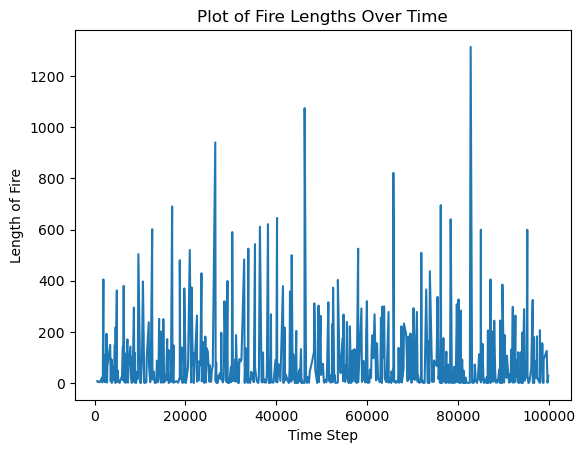

In [8]:
analysis_1.plot_fire_lengths_over_time()

In [4]:
include_lakes = True
lake_proportion = 0.1
sensitivity_analysis = SensitivityAnal(50, 1, 50, 'g', 0.5, 2, 0.5, 10**5, 10, include_lakes, lake_proportion)



[array([ 3,  1,  1, ...,  3, 12, 23])]
[array([ 3,  1,  1, ...,  3, 12, 23]), array([1, 1, 2, ..., 3, 9, 1])]
[array([ 3,  1,  1, ...,  3, 12, 23]), array([1, 1, 2, ..., 3, 9, 1]), array([ 2,  3,  1, ..., 39,  3,  1])]
[array([ 3,  1,  1, ...,  3, 12, 23]), array([1, 1, 2, ..., 3, 9, 1]), array([ 2,  3,  1, ..., 39,  3,  1]), array([ 1,  1,  1, ..., 35,  1,  2])]
[array([ 3,  1,  1, ...,  3, 12, 23]), array([1, 1, 2, ..., 3, 9, 1]), array([ 2,  3,  1, ..., 39,  3,  1]), array([ 1,  1,  1, ..., 35,  1,  2]), array([ 2,  1,  6, ..., 24,  1,  1])]
[array([ 3,  1,  1, ...,  3, 12, 23]), array([1, 1, 2, ..., 3, 9, 1]), array([ 2,  3,  1, ..., 39,  3,  1]), array([ 1,  1,  1, ..., 35,  1,  2]), array([ 2,  1,  6, ..., 24,  1,  1]), array([  1,   1,   2, ..., 140,   1,  23])]
[array([ 3,  1,  1, ...,  3, 12, 23]), array([1, 1, 2, ..., 3, 9, 1]), array([ 2,  3,  1, ..., 39,  3,  1]), array([ 1,  1,  1, ..., 35,  1,  2]), array([ 2,  1,  6, ..., 24,  1,  1]), array([  1,   1,   2, ..., 140,   1

Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
/opt/homebrew/anaconda3/lib/python3.11/site-packages/powerlaw.py:1615: RuntimeWarning: invalid value encountered in divide
  CDF = CDF/norm
'nan' in fit cumulative distribution values.
Likely underflow or overflow error: the optimal fit for this distribution gives values that are so extreme that we lack the numerical precision to calculate them.
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


Assuming nested distributions
Assuming nested distributions


[array([   2,    1,    5,    7,   19,   21,    4,   36,    5,    1,   66,
        673,   70,    1,  164,  217,    1,   80,    4,   26,    8,    4,
         18,    2,    3,   19,   25,  166,   18,  286,   21,   17,   55,
         56,   14,  332,  139,    7,    6,    1,    7,  178,    6,    1,
          4,   11,    3,  430,   61,   29,   20,   70,    3,  530,    5,
          1,   99,  237,    7,  105,    1,  295,    2,  297,   11,   13,
         15,   19,   54,  129,   58,   68,    8,  170,   87,   52,    8,
        320,    3,    2,   44,   73,    6,   55,  476,   11,    1,  145,
          1,    2,   33,   84,   10,    9,  398,    8,   44,    6,    8,
          2,    1,    5,  195,    5,    1,  427,    7,   28,    3,    7,
         98,    7,  123,    1,  112,   44,  170,   50,  140,   15,   11,
        234,   57,   19,  163,    2,   26,    1,    3,   37,    1,   28,
          1,   60,  934,    5,    1,   43,   49,    6,   19,   19,    1,
          1,  227,  967,    2,   45,   46,    3,  

Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


[array([   1,    4,    8,    2,   14,    9,   25,    8,    3,   27,  811,
        129,  408,    6,    2,    7,   17,    6,    6,    5,   60,   45,
          1,   23,  126,    4,    6, 1004,   10,    1,    1,   14,    8,
        120,   59,    7,   21,   13,    1,    1,   97,    9,   27,   19,
         28,   37,    6,    2,   11,  170,   67,  330,    1,    4,   23,
          1,   18,   26,    5,  670,    2,    3,   12,   23,   10,    1,
          2,    8,  181,  575,   39,   20,  201,    4,    1,  177,   12,
         46,    2,   19,  299,    4,    3,   93,  125,  162,   16,    1,
          4,    4,    3,   25,  730,  113,    5,    2,    2,    5,   60,
          1,   92,    1,  231,    1,    2,    4,    4,  261,    1,  252,
         45,  327,    3,    9,    8,  152,   34,    5,  203,   16,   87,
        263,    1,   38,   18,    1,   51,    6,  210,    5,   10,    1,
        104,  119,  119,   41,   26,  129,    1,    4,    1,    1,   28,
         39,  264,   50,  124,  105,   79,    4,  

Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


[array([  2,   5,   1,  10,   2,   4,  14,  53,  29,  24,  37, 293,  14,
       830,   7,  13,   4,   7,   7,  52,  68,  39,   1, 440, 209,   1,
        69,  13,  50,  15,  12, 168,   2,  74, 115,   1,   4,   3,   7,
       105,  44,   1, 109, 465,  49,  13,   3,  45,   8,   1,   7,   1,
        22, 333, 349,   3,  30,  18, 255,   6,   2,  53,   8,   4,  64,
         1,  41,  88, 132,   1,  75,   5,  60, 554,  14,  13,  40,   5,
        87,  19,  11,   1,   5, 297,  26,   1,   1,  62,   1,   1, 120,
         1,  86, 524,   1,   2,   1,   1,  13,   7,  43, 512,   3,  61,
         1,  64, 230,  42,   3,   4,  51, 439,   1,  16,  26, 208,   6,
        64,   9,  18,   4, 440,  12, 191,   2,  11,  13,   9, 699, 112,
        13, 181,   1,  69, 391,  15,  10,  23,   1,   1,  13,  24, 172,
         2, 637,  32,   1,   1,   1,  24,  15,   1,   7,  13,   8,  46,
       874,   1,   2,   2,   1,   4,   1, 340,  98,  10, 265,  85,  76,
         1,  12, 160, 174,   2,   4, 200,   9,   2,  18, 130, 3

Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions
Assuming nested distributions


Assuming nested distributions
Assuming nested distributions


[array([  2,   2,   5, ..., 123,   3,   4])]
[array([  2,   2,   5, ..., 123,   3,   4]), array([ 1,  1,  1, ..., 22, 44, 23])]
[array([  2,   2,   5, ..., 123,   3,   4]), array([ 1,  1,  1, ..., 22, 44, 23]), array([ 1,  1,  1, ..., 24, 19, 22])]
[array([  2,   2,   5, ..., 123,   3,   4]), array([ 1,  1,  1, ..., 22, 44, 23]), array([ 1,  1,  1, ..., 24, 19, 22]), array([ 2,  3,  1, ..., 43,  1,  2])]
[array([  2,   2,   5, ..., 123,   3,   4]), array([ 1,  1,  1, ..., 22, 44, 23]), array([ 1,  1,  1, ..., 24, 19, 22]), array([ 2,  3,  1, ..., 43,  1,  2]), array([1, 1, 3, ..., 5, 1, 9])]
[array([  2,   2,   5, ..., 123,   3,   4]), array([ 1,  1,  1, ..., 22, 44, 23]), array([ 1,  1,  1, ..., 24, 19, 22]), array([ 2,  3,  1, ..., 43,  1,  2]), array([1, 1, 3, ..., 5, 1, 9]), array([  1,   1,   2, ...,   8,   3, 110])]
[array([  2,   2,   5, ..., 123,   3,   4]), array([ 1,  1,  1, ..., 22, 44, 23]), array([ 1,  1,  1, ..., 24, 19, 22]), array([ 2,  3,  1, ..., 43,  1,  2]), array([

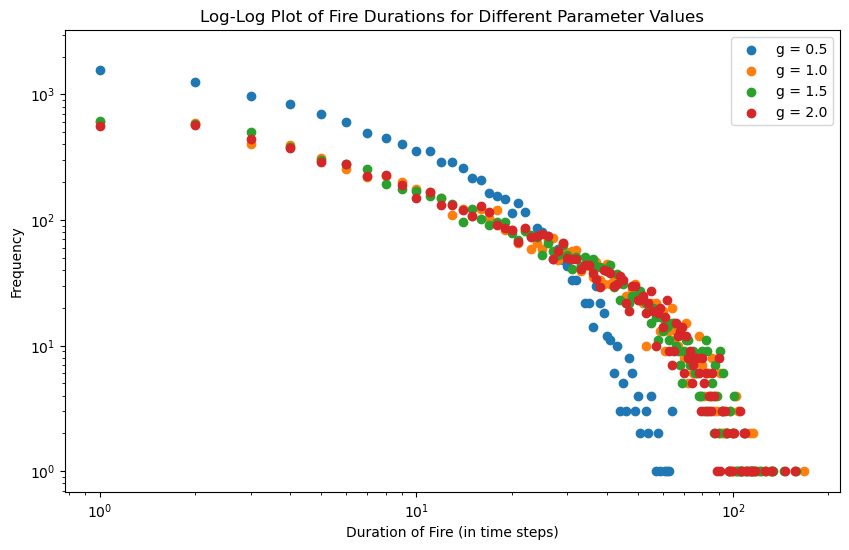

[array([ 1,  1,  1, ...,  4,  4, 83])]
[array([ 1,  1,  1, ...,  4,  4, 83]), array([ 3,  1,  8, ...,  1, 14,  5])]
[array([ 1,  1,  1, ...,  4,  4, 83]), array([ 3,  1,  8, ...,  1, 14,  5]), array([ 2,  1,  4, ...,  1, 11, 25])]
[array([ 1,  1,  1, ...,  4,  4, 83]), array([ 3,  1,  8, ...,  1, 14,  5]), array([ 2,  1,  4, ...,  1, 11, 25]), array([ 1,  1,  1, ..., 13,  3,  1])]
[array([ 1,  1,  1, ...,  4,  4, 83]), array([ 3,  1,  8, ...,  1, 14,  5]), array([ 2,  1,  4, ...,  1, 11, 25]), array([ 1,  1,  1, ..., 13,  3,  1]), array([  1,   3,   1, ...,  16, 101,   2])]
[array([ 1,  1,  1, ...,  4,  4, 83]), array([ 3,  1,  8, ...,  1, 14,  5]), array([ 2,  1,  4, ...,  1, 11, 25]), array([ 1,  1,  1, ..., 13,  3,  1]), array([  1,   3,   1, ...,  16, 101,   2]), array([  1,   1,   1, ...,   7, 121,   1])]
[array([ 1,  1,  1, ...,  4,  4, 83]), array([ 3,  1,  8, ...,  1, 14,  5]), array([ 2,  1,  4, ...,  1, 11, 25]), array([ 1,  1,  1, ..., 13,  3,  1]), array([  1,   3,   1, ...

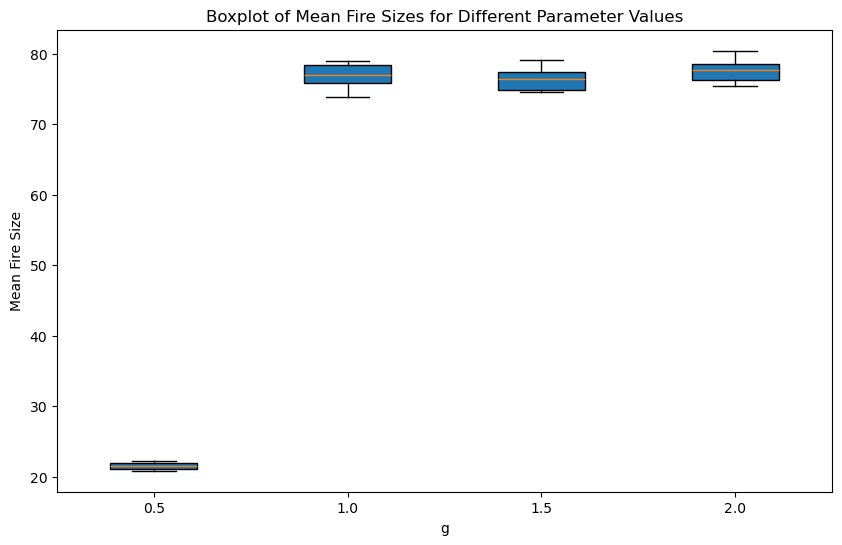

[array([  5,   1,   3, ...,   1, 122,  61])]
[array([  5,   1,   3, ...,   1, 122,  61]), array([  1,   1,   1, ...,  50, 199,  21])]
[array([  5,   1,   3, ...,   1, 122,  61]), array([  1,   1,   1, ...,  50, 199,  21]), array([1, 1, 2, ..., 2, 4, 1])]
[array([  5,   1,   3, ...,   1, 122,  61]), array([  1,   1,   1, ...,  50, 199,  21]), array([1, 1, 2, ..., 2, 4, 1]), array([ 1,  4,  1, ...,  1, 69, 15])]
[array([  5,   1,   3, ...,   1, 122,  61]), array([  1,   1,   1, ...,  50, 199,  21]), array([1, 1, 2, ..., 2, 4, 1]), array([ 1,  4,  1, ...,  1, 69, 15]), array([ 1,  1,  1, ..., 70,  2,  2])]
[array([  5,   1,   3, ...,   1, 122,  61]), array([  1,   1,   1, ...,  50, 199,  21]), array([1, 1, 2, ..., 2, 4, 1]), array([ 1,  4,  1, ...,  1, 69, 15]), array([ 1,  1,  1, ..., 70,  2,  2]), array([ 1,  5,  3, ..., 47,  4, 49])]
[array([  5,   1,   3, ...,   1, 122,  61]), array([  1,   1,   1, ...,  50, 199,  21]), array([1, 1, 2, ..., 2, 4, 1]), array([ 1,  4,  1, ...,  1, 69, 1

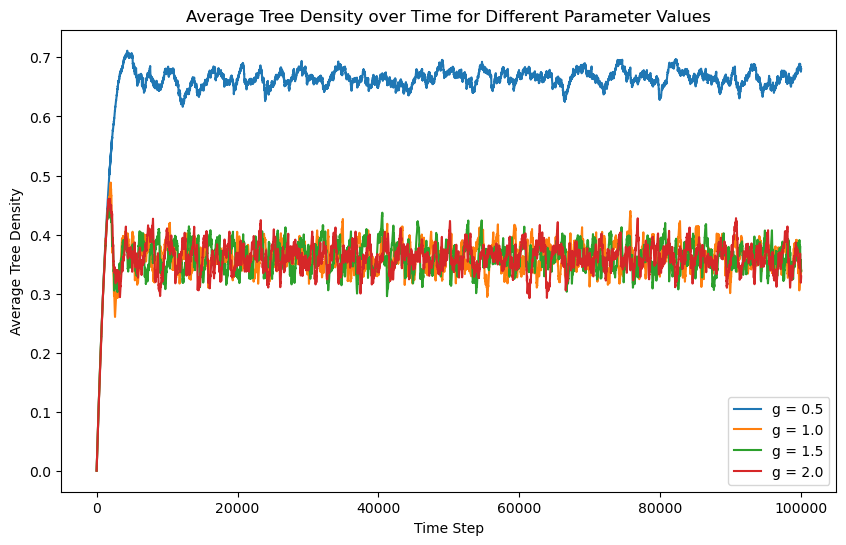

In [6]:
sensitivity_analysis.run()
sensitivity_analysis.make_fire_duration_log_log_plot()
sensitivity_analysis.make_mean_fire_size_boxplot()
sensitivity_analysis.plot_average_tree_densities()

_________________

In [3]:
# (2)
analysis_1.find_proportion_power_law()
print(f'{analysis_1.proportion_power_law * 100}% of the model instances are best fitted by a power law distribution')
analysis_1.log_log_plot()

AttributeError: 'Analyse' object has no attribute 'find_proportion_power_law'

100.0% of the model instances converge to a quasi equilibrium state


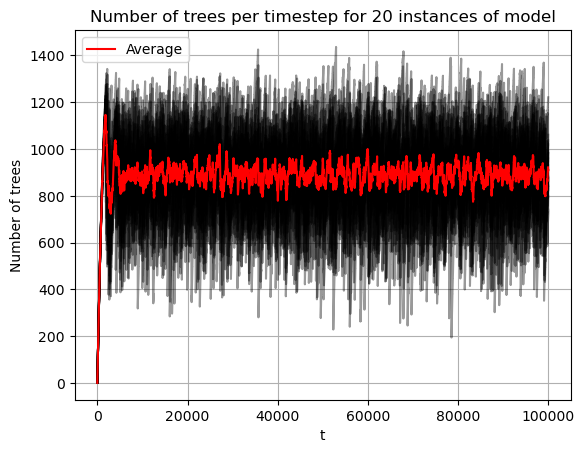

In [3]:
# (3)
proportion_stable = analysis_1.find_proportion_stable(0.01)
print(f'{proportion_stable * 100}% of the model instances converge to a quasi equilibrium state')
analysis_1.plot_number_trees_timeseries()

AttributeError: 'Analyse' object has no attribute 'find_proportion_power_law'

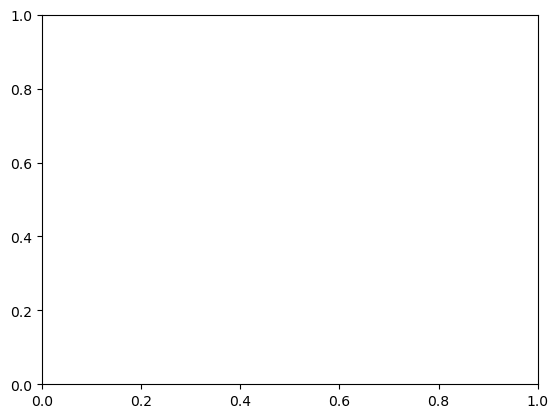

In [5]:
fig, ax = plt.subplots()


L = 100
g = 1
f = 50
timesteps = 10**2
instances = 20
freeze_time_during_fire = False
remember_history = False
analysis_1 =  Analyse(L, g, f, freeze_time_during_fire, remember_history, timesteps, instances, 0.1, False)
analysis_1.run_all()

# (2)
label = f't={timesteps}'
analysis_1.find_proportion_power_law()
print(f'{analysis_1.proportion_power_law * 100}% of the model instances are best fitted by a power law distribution')
analysis_1.log_log_plot(ax, fig, label=label)


timesteps = 10**3
label = f't={timesteps}'

analysis_1 =  Analyse(L, g, f, freeze_time_during_fire, remember_history, timesteps, instances, 0.1 , False)
analysis_1.run_all()

analysis_1.find_proportion_power_law()
print(f'{analysis_1.proportion_power_law * 100}% of the model instances are best fitted by a power law distribution')
analysis_1.log_log_plot(ax, fig, color='orange', label=label)


timesteps = 10**4
label = f't={timesteps}'

analysis_1 =  Analyse(L, g, f, freeze_time_during_fire, remember_history, timesteps, instances, 0.1, False)
analysis_1.run_all()

analysis_1.find_proportion_power_law()
print(f'{analysis_1.proportion_power_law * 100}% of the model instances are best fitted by a power law distribution')
analysis_1.log_log_plot(ax, fig, color='blue', label=label)



timesteps = 10**5
label = f't={timesteps}'

analysis_1 =  Analyse(L, g, f, freeze_time_during_fire, remember_history, timesteps, instances)
analysis_1.run_all()

analysis_1.find_proportion_power_law()
print(f'{analysis_1.proportion_power_law * 100}% of the model instances are best fitted by a power law distribution')
analysis_1.log_log_plot(ax, fig, color='green', label=label, show=True)

In [6]:
freeze_time_during_fire = False
timesteps = 1500000
analysis_2 =  Analyse(L, g, f, freeze_time_during_fire, remember_history, timesteps, instances)
analysis_2.run_one_instance(0)


In [7]:
# (2)
analysis_2.find_proportion_power_law()
print(f'{analysis_2.proportion_power_law * 100}% of the model instances are best fitted by a power law distribution')
analysis_2.log_log_plot()

AttributeError: 'Analyse' object has no attribute 'find_proportion_power_law'

In [ ]:
# (3)
proportion_stable = analysis_2.find_proportion_stable(0.01)
print(f'{proportion_stable * 100}% of the model instances converge to a quasi equilibrium state')
analysis_2.plot_number_trees_timeseries()

Ilias Data analys

In [ ]:
# Parameters
size: tuple = (50, 50) 
tree_density: float = 0.01
iterations: int = 50000
fire_start: tuple = (250, 250)
growth_prob: float = 0.001
ortho_burn_prob: float = 0.8
diag_burn_prob: float = 0.8
lightning_prob: float = 0.0001 
FireLength: int  = 0
arrayOfFireLengths: list[int] = []
forest = initialize_forest(size=size, tree_density=tree_density) 

In [ ]:
FireLength, arrayOfFireLengths  = run_simulation(size=size, tree_density=tree_density, iterations=iterations, fire_start=fire_start, growth_prob=growth_prob, lightning_prob=lightning_prob, ortho_burn_prob=ortho_burn_prob, diag_burn_prob=diag_burn_prob, FireLength=FireLength, arrayOfFireLengths=arrayOfFireLengths)


In [ ]:
y = np.bincount(arrayOfFireLengths)
x = np.nonzero(a=y)[0]
plt.scatter(x=x, y=y[x])
plt.xscale(value='log')
plt.yscale(value='log')
plt.show()
plt.hist(arrayOfFireLengths, bins=50)
plt.show()
results = powerlaw.Fit(data=arrayOfFireLengths)
print(results.power_law.alpha)
print(results.power_law.xmin)
R, p = results.distribution_compare(dist1='truncated_power_law', dist2='lognormal')
print(R, p)

In [ ]:
unique_identifiers = range(len(arrayOfFireLengths))
plt.plot(unique_identifiers, arrayOfFireLengths)

plt.xlabel('Fire Events')
plt.ylabel('Length of Fire')
plt.title('Bar Plot of Fire Lengths Over Time')

plt.show()

In [ ]:
print(max(arrayOfFireLengths))


In [ ]:
# Total number of clusters
from collections import Counter


total_clusters = len(arrayOfFireLengths)
frequency_distribution = Counter(arrayOfFireLengths)
# Normalizing by the total number of clusters
n_s_clusters = {s: freq / total_clusters for s, freq in frequency_distribution.items()}


# Normalizing by the total number of sites
# n_s_sites = {s: freq / total_sites for s, freq in frequency_distribution.items()}
# Prepare data for plotting
cluster_sizes = np.array(list(n_s_clusters.keys()))/max(arrayOfFireLengths)
frequencies = np.array(list(n_s_clusters.values()))

# Filter out zero frequencies for log-log plot
nonzero_indices = frequencies > 0
cluster_sizes = cluster_sizes[nonzero_indices]
frequencies = frequencies[nonzero_indices]

# Create a log-log plot
plt.figure(figsize=(10, 6))
plt.loglog(cluster_sizes, frequencies, 'o')  
plt.xlabel(xlabel='Cluster Size (s)')
plt.ylabel(ylabel='Normalized Frequency (n(s))')
plt.title(label='Log-Log Plot of Cluster Size Distribution')
plt.grid(visible=True)
plt.show()